Usé como base de datos una colección de 4187  imágenes de un juego de cartas (yugioh), cada imagen tiene por nombre el 'id' de la carta. El objetivo es que el modelo pueda diferenciar entre los tres tipos principales de cartas: Mounstruos, Trampas y Magias.

Para ello busqué una base de datos que contuviera la clasificación asociada al 'id' de cada carta.

Encontré la base de datos completa para todas las carta. Esta contiene la información asociada a mas de 10 mil distintos 'id'. Esta base tiene su propia nomenclatura para identificar los tipos de cartas.

Manualmente, usando autofiltros en una hoja de cálculo, etiqueté las cartas de mi interés, en una columna nombrada 'Category', asignando 1 a los mounstruos, 2 a las magias y 3 a las trampas.

Al asignar estos valres dejé fuera algunos tipos de la clase de mounstruos que consideré podrían ser díficiles de identificar.

La base de datos resultante cvs tiene la información asociada a 12364 'id's distintos, y es el archivo que nombré 'clean_cdb.cvs'



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import cv2
from sklearn.model_selection import train_test_split

En la siguiente parte de código, apoyándome de inteligencia artificial, obtuve los dos arreglos de los cual obtendría el arreglo de entradas y el arreglo de salidas para crear los X_train, y_train, X_test y y_test. Crear estos arreglos suponía los siguientes problemas



*   Deberían elegirse **sólo** las imágenes listadas en clean_cdb.cvs
*   Al crear el arreglo con las imágenes adecuadas, ahora había que crear el arreglo con las salidas de **sólo** las imágenes que se habían encontrado en el folder 'pics'



In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import os

def create_image_dataset(csv_path, image_folder, id_column='id', target_size=(177, 254)):
    """
    Creates synchronized image array and DataFrame from CSV and image folder

    Args:
        csv_path: Path to CSV file
        image_folder: Folder containing JPG images
        id_column: Name of ID column in CSV
        target_size: Target image dimensions (width, height)

    Returns:
        Tuple of (image_array, filtered_df) where:
        - image_array: numpy ndarray of shape (n_images, height, width, 3) [RGB]
        - filtered_df: Subset of original DataFrame with matching images
    """
    # 1. Read CSV and prepare ID list
    df = pd.read_csv(csv_path)
    required_ids = set(df[id_column].astype(str))

    # 2. Scan image folder and find matches
    matched_ids = []
    matched_images = []

    for filename in os.listdir(image_folder):
        if not filename.lower().endswith(('.jpg', '.jpeg')):
            continue

        file_id = os.path.splitext(filename)[0]
        if file_id in required_ids:
            try:
                img_path = os.path.join(image_folder, filename)
                img = Image.open(img_path)

                # Convert to RGB (in case some are grayscale or RGBA) and resize
                img_rgb = img.convert('RGB').resize(target_size, Image.Resampling.LANCZOS)
                img_array = np.array(img_rgb)

                # Verify size (now expecting height, width, 3)
                if img_array.shape[:2] == target_size[::-1] and img_array.shape[2] == 3:
                    matched_images.append(img_array)
                    matched_ids.append(file_id)
                else:
                    print(f"Size/Channel mismatch in {filename}: expected {target_size} with 3 channels, got {img_array.shape}")

            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    # 3. Create synchronized outputs
    if not matched_ids:
        raise ValueError("No matching images found!")

    # Create image array (n_images, height, width, 3)
    image_array = np.stack(matched_images)

    # Filter and order DataFrame to match image array
    id_to_index = {id_: idx for idx, id_ in enumerate(matched_ids)}
    filtered_df = df[df[id_column].astype(str).isin(matched_ids)].copy()

    # Add temporary column for sorting
    filtered_df['__sort_order__'] = filtered_df[id_column].astype(str).map(id_to_index)
    filtered_df = filtered_df.sort_values('__sort_order__').drop('__sort_order__', axis=1)

    # Verify synchronization
    assert len(filtered_df) == len(image_array), "DataFrame and array length mismatch!"
    assert all(filtered_df[id_column].astype(str) == matched_ids), "Order mismatch!"

    return image_array, filtered_df

In [3]:
image_array, filtered_df = create_image_dataset('/content/drive/MyDrive/Colab Notebooks/Modulo VI/clean_cdb.csv', '/content/drive/MyDrive/LA HORA-YGO-/pics')

In [4]:
#Verificamos que tenga las dimensiones adecuadas segun el código que construimos en la última sesión.
print(image_array.shape)
print(filtered_df.shape)
filtered_df.head()

(3109, 254, 177, 3)
(3109, 5)


id  ot  alias  type  Category
9087  72903645   3      0    33         1
9103  73051941   3      0    17         1
9104  73055622   3      0   130         2
9143  73359475   3      0    33         1
9125  73213494   3      0    33         1

A continuación imprimo 5 entradas del arreglo de imágenes para compararlo con el arreglo de salidas (mostrado en la celda anterior) y ver que se ha llevado correctamente la construcción de ambos arreglos.

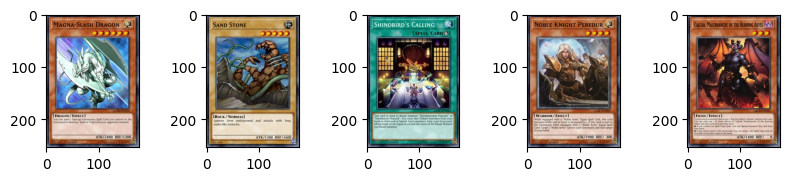

In [5]:
plt.figure(figsize=(10,10))
for i in range(5):
  plt.subplot(5,5,i+1)
  plt.imshow(image_array[i], cmap='gray')
plt.show()

In [6]:
#Al ver que los arreglos de imágenes y de la base de datos coinciden en orden, me quedo
# únicamente con mi columna objetivo 'Category'
y=filtered_df['Category']
y.shape

(3109,)

In [7]:
#Código para hacer la separación del entrenamiento y validación

def train_test_split_data(X, y, test_size=0.2, random_state=42):
    """
    Split image data and labels into training and test sets

    Args:
        X: Image array (n_samples, height, width)
        y: Label array (n_samples,)
        test_size: Proportion for test set (default 0.2 for 80:20 split)
        random_state: Random seed for reproducibility

    Returns:
        X_train, X_test, y_train, y_test
    """
    # Ensure inputs are numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Verify shapes match
    assert len(X) == len(y), "X and y must have the same number of samples"

    # Perform the split (stratified by default for classification)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
        stratify=y  # Remove this for regression problems
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    print(f"Split ratio: {len(X_train)/len(X):.1f}:{len(X_test)/len(X):.1f}")

    return X_train, X_test, y_train, y_test

In [8]:
#Definicion de filtro HSV
def apply_hsv_filter(image_array):
    """
    Convert an array of RGB images to HSV color space

    Args:
        image_array: numpy array of shape (n_images, height, width, 3) in RGB

    Returns:
        numpy array of shape (n_images, height, width, 3) in HSV
    """
    hsv_images = []
    for img in image_array:
        # Convert RGB to HSV (OpenCV expects BGR by default)
        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hsv_images.append(hsv_img)

    return np.stack(hsv_images)

In [32]:
#Definicion filtro grayscale
def convert_to_grayscale(image_array):
    """
    Convert an array of RGB images to grayscale

    Args:
        image_array: numpy array of shape (n_images, height, width, 3) in RGB

    Returns:
        numpy array of shape (n_images, height, width, 1) in grayscale
    """
    grayscale_images = []
    for img in image_array:
        # Convert RGB to grayscale and add channel dimension
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray_img = np.expand_dims(gray_img, axis=-1)  # Shape becomes (h,w,1)
        grayscale_images.append(gray_img)

    return np.stack(grayscale_images)

## Filtro HSV

El filtro HSV lo elegí porque separa la información de color de la de brillo. Y dado que los tipos de cartas se pueden diferenciar por su color me pareció una buena opción.

In [14]:
#Seleccion de filtro
  #apply HSV filter
hsv_array = apply_hsv_filter(image_array)
f_i_array=hsv_array

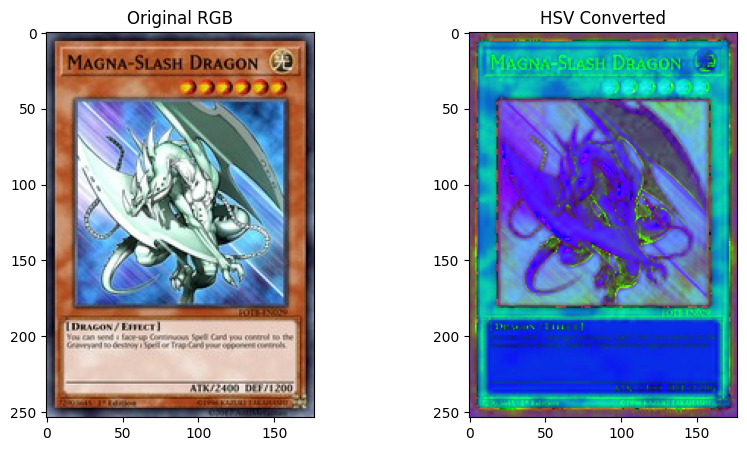

In [15]:
# Optional: Visualize before/after
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("Original RGB")
plt.imshow(image_array[0])
plt.subplot(122)
plt.title("HSV Converted")
plt.imshow(hsv_array[0])
plt.show()

In [16]:
# Usage example:
X_train, X_test, y_train, y_test = train_test_split_data(f_i_array, y, test_size=0.2)

Training set: 2487 samples
Test set: 622 samples
Split ratio: 0.8:0.2


In [18]:
y_train = y_train-1
y_test = y_test-1

In [19]:
#Convertir etiquetas a one-hot
##EJEMPLO###
# el núnmero 3 a one-hot --- [0,0,0,1,......,0]
#el numero cero a one hot quedaria [1,0,...,0]
y_train = to_categorical(y_train,3)
y_test = to_categorical(y_test,3)

In [20]:
print(y_train.shape)
print(y_test.shape)

(2487, 3)
(622, 3)


In [17]:
print(X_train.shape)

(2487, 254, 177, 3)


In [24]:
#El código ha sido modificado porque el tamaño de las imágenes es mayor,
#además de que estamos usando imágenes a color y por lo tanto el input_shape tiene ahora tres canales
##ARQUITECTURA DE LA CONVOLUCIONAL####

model = keras.Sequential([
    # First Conv block - larger kernel for initial downsampling
    layers.Conv2D(32, kernel_size=(7,7), activation='relu', input_shape=(254, 177, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Second Conv block
    layers.Conv2D(64, kernel_size=(5,5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Third Conv block
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Fourth Conv block
    layers.Conv2D(256, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Changed to 3 for your 3 classes
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 248, 171, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 124, 85, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 120, 81, 64)    │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 60, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 58, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 29, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 27, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 26624)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    13,632,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,058,563 (53.63 MB)

 Trainable params: 14,058,563 (53.63 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
#Compilación del modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
#Entrenar modelo

batch_size=64 ##Reduccion en el batch_size porque en mi proyecto las imagenes son de mayor tamamño
epochs = 10

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.1
)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 32s 558ms/step - accuracy: 0.6451 - loss: 59.0224 - val_accuracy: 0.9799 - val_loss: 0.1008
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.9665 - loss: 0.0813 - val_accuracy: 0.9960 - val_loss: 0.0169
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9928 - loss: 0.0208 - val_accuracy: 1.0000 - val_loss: 3.8033e-04
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9215 - loss: 0.4115 - val_accuracy: 0.9960 - val_loss: 0.0098
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9981 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9920 - val_loss: 0.0192
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9993 - loss: 0.0050 - val_accuracy: 0.9960 - val_loss: 0.0140
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9995 - loss: 7.2328e-04 - val_a

In [27]:
test_loss, test_acc= model.evaluate(X_test, y_test, verbose =0)
print(f"\nPrecisión en el conjunto de prueba:{test_acc:.4f}")


Precisión en el conjunto de prueba:1.0000


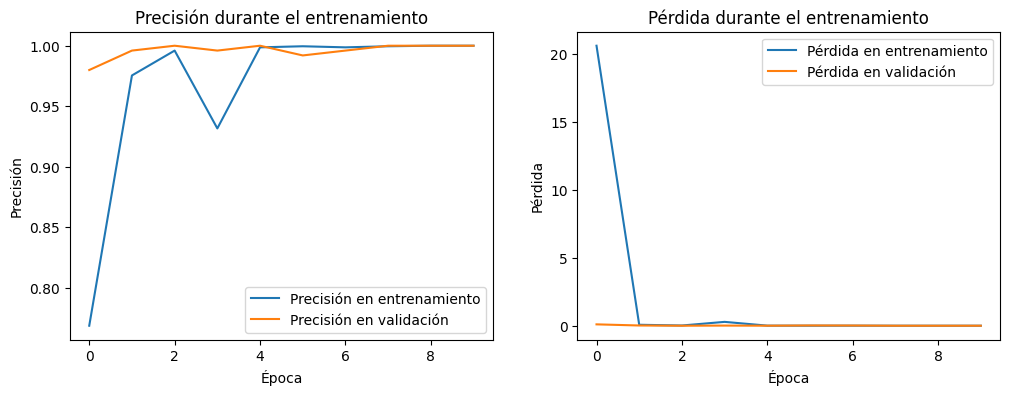

In [28]:
plt.figure(figsize=(12, 4)) ###grafica de precision durante entr
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2) ##graf perdida durante entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


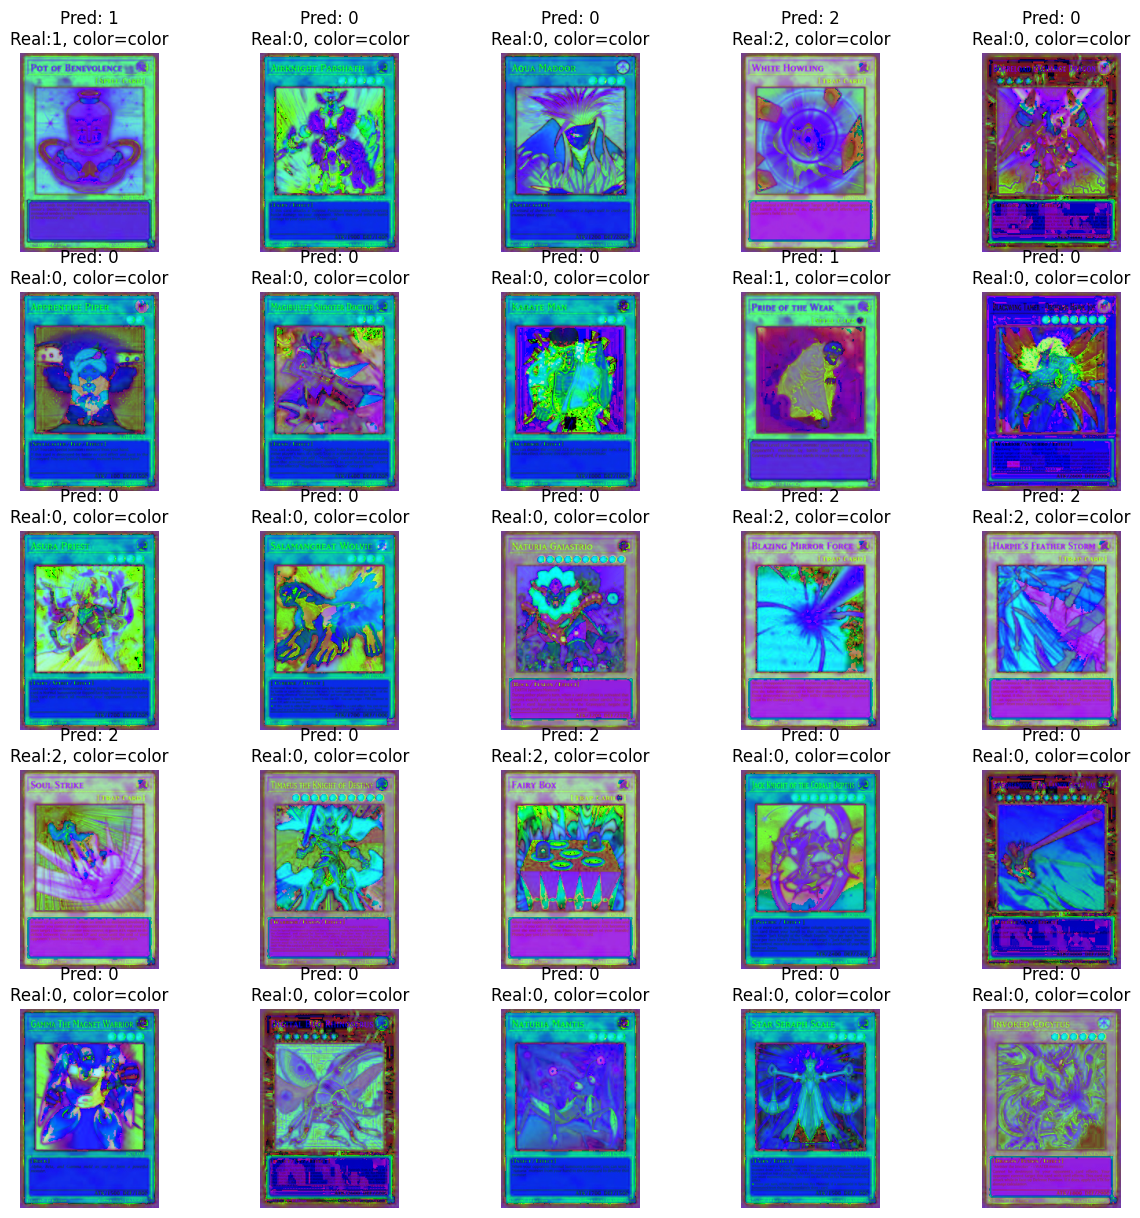

In [29]:
#Funciona el codigo#

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test,axis=1)

plt.figure(figsize=(15,15))
for i in range (25):
  plt.subplot(5,5,i+1)
  plt.imshow(X_test[i].squeeze(), cmap='gray')
  color ='green' if predicted_labels[i] == true_labels[i] else 'red'
  plt.title(f"Pred: {predicted_labels[i]}\nReal:{true_labels[i]}, color=color")
  plt.axis('off')
plt.show()

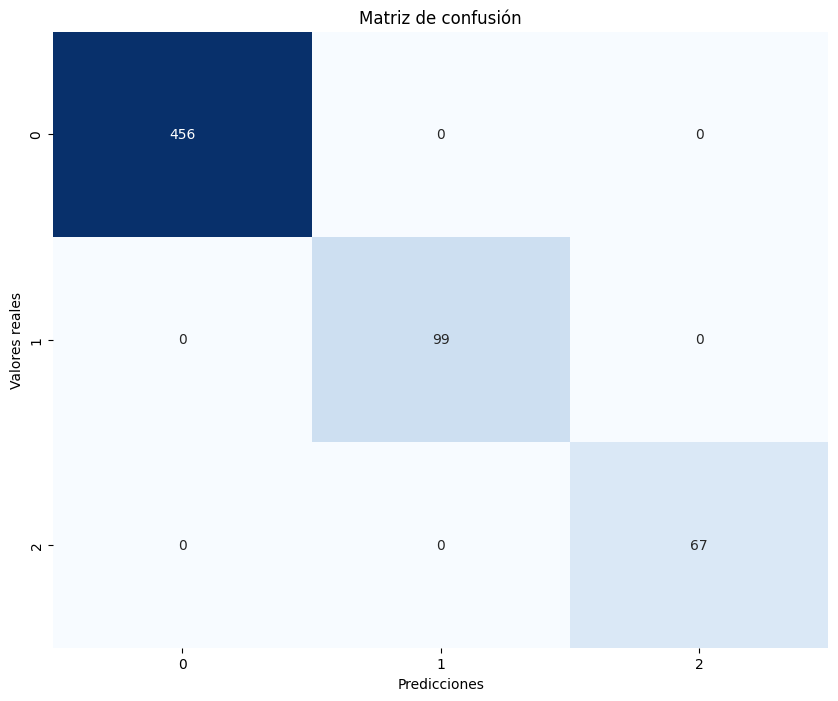

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()

## Filtro Grayscale

Escogí el filtro Grayscale porque, si bien el color clasifica los tipos de carta, la sección debajo del nombre de la carta también contiene informarción suficiente para identificar la carta sin necesidad del color. Lo cual ahorra la cantidad de información necesaria para entrenar al modelo.

In [33]:
gray_array = convert_to_grayscale(image_array)

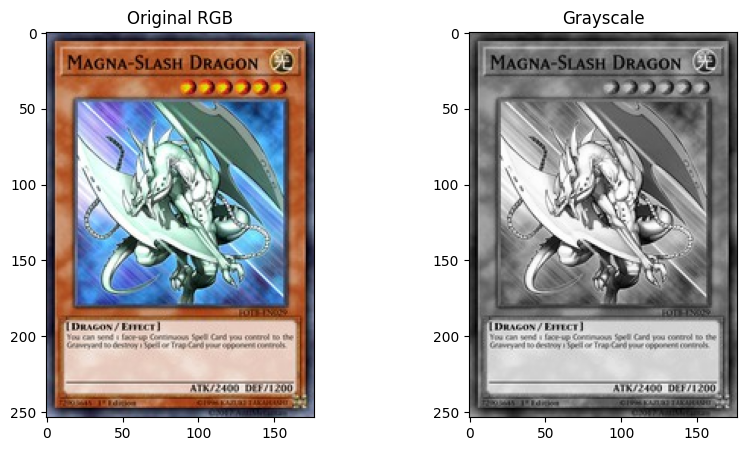

In [36]:
# Optional: Visualize before/after
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("Original RGB")
plt.imshow(image_array[0])
plt.subplot(122)
plt.title("Grayscale")
plt.imshow(gray_array[0].squeeze(), cmap='gray')  # Remove channel dim for display
plt.show()

In [37]:
# Usage example:
X_train, X_test, y_train, y_test = train_test_split_data(gray_array, y, test_size=0.2)

Training set: 2487 samples
Test set: 622 samples
Split ratio: 0.8:0.2


In [ ]:
X_train = X_train.astype('float32')/255 #Normalización
X_test = X_test.astype('float32')/255

In [38]:
y_train = y_train-1
y_test = y_test-1

In [39]:
#Convertir etiquetas a one-hot
##EJEMPLO###
# el núnmero 3 a one-hot --- [0,0,0,1,......,0]
#el numero cero a one hot quedaria [1,0,...,0]
y_train = to_categorical(y_train,3)
y_test = to_categorical(y_test,3)

In [40]:
print(y_train.shape)
print(y_test.shape)

(2487, 3)
(622, 3)


In [41]:
print(X_train.shape)

(2487, 254, 177, 1)


In [42]:
print(y_train.shape)
print(y_test.shape)

(2487, 3)
(622, 3)


In [43]:
##ARQUITECTURA DE LA CONVOLUCIONAL####

model = keras.Sequential([
    # First Conv block - larger kernel for initial downsampling
    layers.Conv2D(32, kernel_size=(7,7), activation='relu', input_shape=(254, 177, 1)),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Second Conv block
    layers.Conv2D(64, kernel_size=(5,5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Third Conv block
    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Fourth Conv block
    layers.Conv2D(256, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Changed to 3 for your 3 classes
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 248, 171, 32)   │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 124, 85, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 120, 81, 64)    │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 60, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 58, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 29, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 27, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 13, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 26624)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    13,632,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,055,427 (53.62 MB)

 Trainable params: 14,055,427 (53.62 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
#Compilación del modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
#Entrenar modelo

batch_size=64 ##Reduccion en el batch_size porque en mi proyecto las imagenes son de mayor tamamño
epochs = 10

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.1
)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - accuracy: 0.5982 - loss: 25.8551 - val_accuracy: 0.7871 - val_loss: 0.3558
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.8610 - loss: 0.2829 - val_accuracy: 0.9277 - val_loss: 0.1300
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9562 - loss: 0.1166 - val_accuracy: 0.9719 - val_loss: 0.0513
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9933 - loss: 0.0318 - val_accuracy: 0.9920 - val_loss: 0.0466
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9744 - loss: 0.0712 - val_accuracy: 0.9639 - val_loss: 0.0867
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9979 - loss: 0.0112 - val_accuracy: 0.9960 - val_loss: 0.0233
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9985 - loss: 0.0057 - val_accuracy: 0.9960 - val_loss: 0.0098
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9992 - loss: 0.0031 - val_accuracy: 0.9960

In [46]:
test_loss, test_acc= model.evaluate(X_test, y_test, verbose =0)
print(f"\nPrecisión en el conjunto de prueba:{test_acc:.4f}")


Precisión en el conjunto de prueba:0.9984


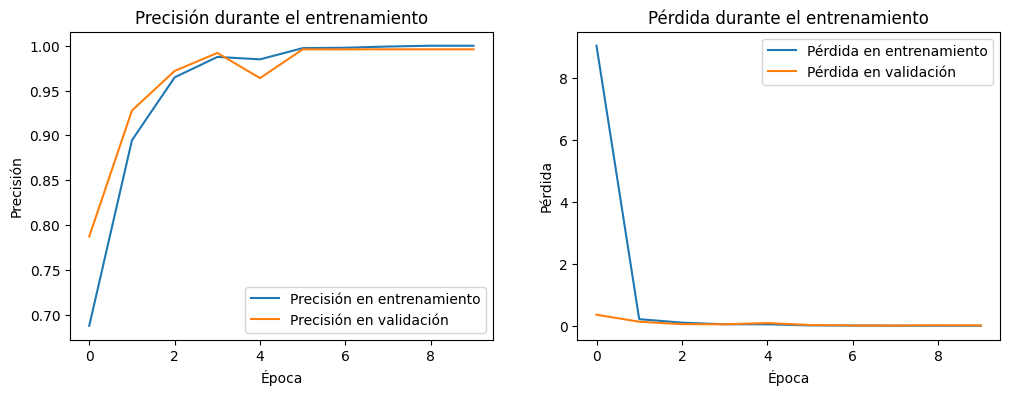

In [47]:
plt.figure(figsize=(12, 4)) ###grafica de precision durante entr
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2) ##graf perdida durante entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


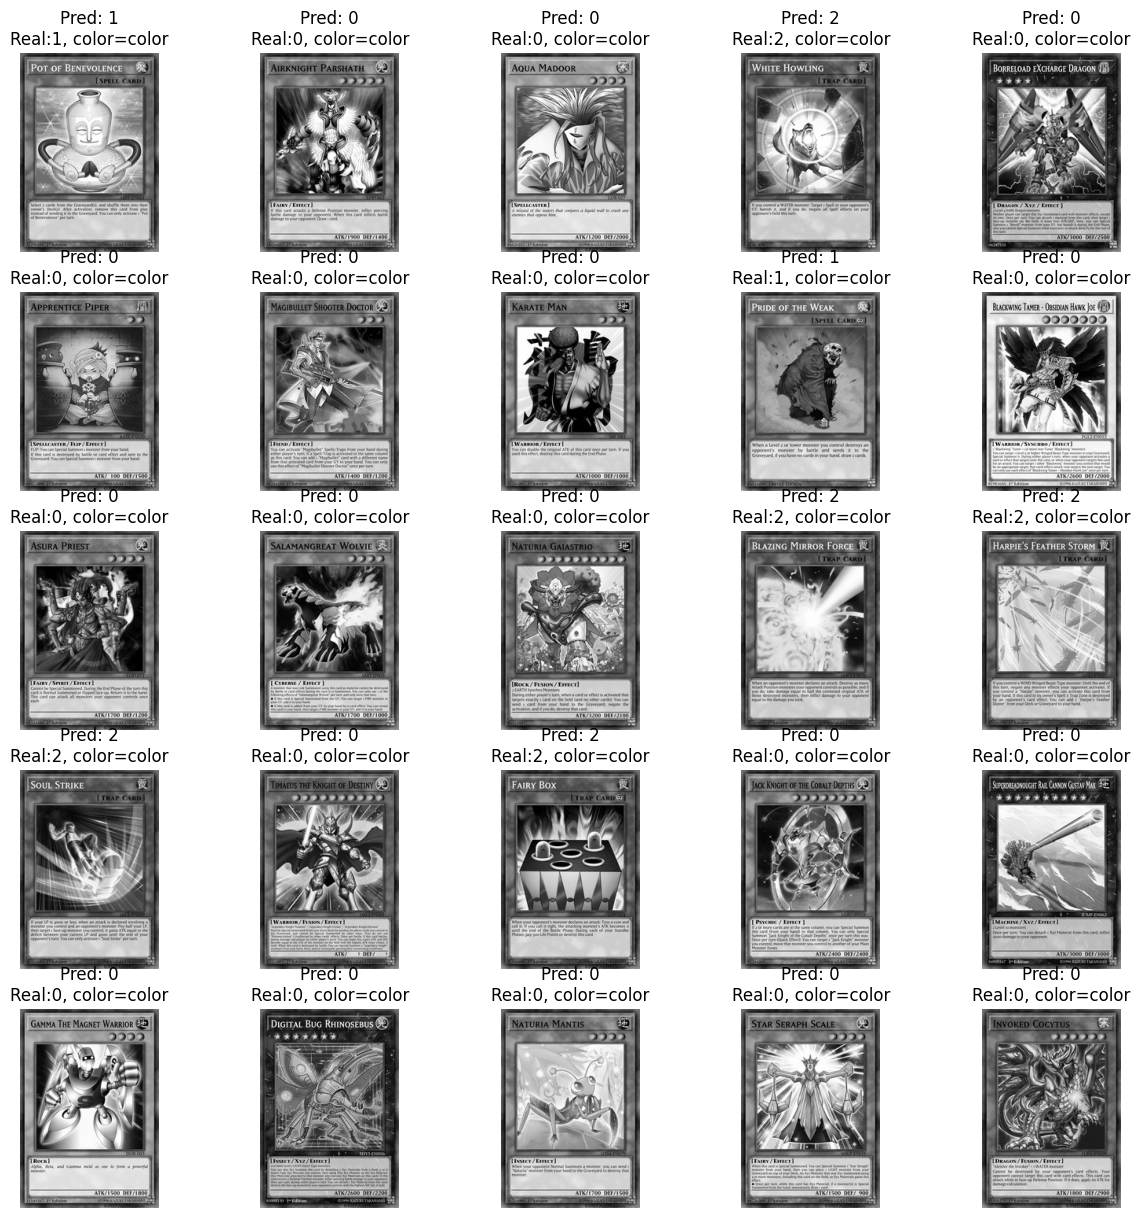

In [48]:
#Funciona el codigo#

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test,axis=1)

plt.figure(figsize=(15,15))
for i in range (25):
  plt.subplot(5,5,i+1)
  plt.imshow(X_test[i].squeeze(), cmap='gray')
  color ='green' if predicted_labels[i] == true_labels[i] else 'red'
  plt.title(f"Pred: {predicted_labels[i]}\nReal:{true_labels[i]}, color=color")
  plt.axis('off')
plt.show()

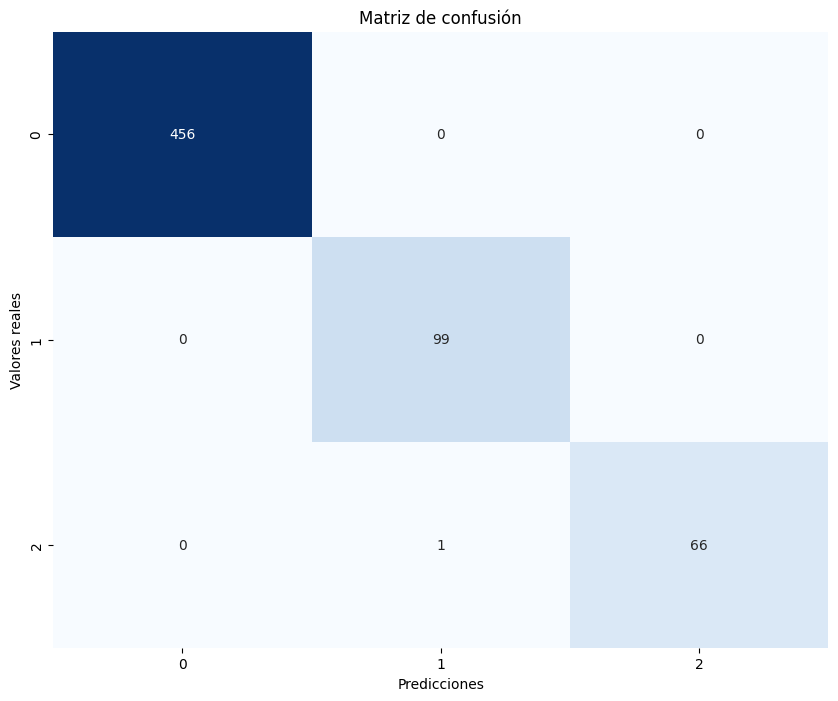

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()

## Conclusiones

Podemos ver que ambos modelos funcionan muy bien, con eficacia arriba del 95 porciento. Aplicar el  filtro HSV arroja una precisión del 100 porciento. Este resultado se alinea con la suposición de que un modelo que tome en consideración el color de las cartas podría clasificar mejor las cartas, ya que su tipo está codificado también en su color.

Sin embargo, aplicando el filtro escala de grises, obtuvimos virtualmente igual de bueno. Y al reducir la cantidad de información se vuelve más fácil de manipular y ejecutar.

Para este caso la elección de filtro dependerá del poder de cómputo para entrenar el modelo.